# universal estimator

## Exp-1
Show that the error decreases when the parameter search space gets smaller.

**Research question**: Is the search space size of the parameter $d$ of a univariate distribution $f(d)$ has an affect on the learning and the prediction errors?

Let $f(d)$ be a one dimensional function, that returns a samples vector drawn from a univariate distribution (e.g., log-normal).

1. Generate a sample (256 observations) using $f$ e.g: $sample = f(d=0.92, size=256)$
2. Write a function: $estimator(f, sample)$ which learns the parameter $d$ of $f$ from the sample.

> - Init: search_space = (0,1)
> - Iterate:
>   1. Generate synthetic data-sets ( train / test ) using $f$ (within the parameter search space)
>   2. Fit a DNN model, error = | pred-set - test-set |
>   3. Predict the parameter $d\_pred$ on the input sample
>   4. Narrow the search space:
>          pivot = d_pred # parameter predicted on input sample using learning model
>          margin = 2 * std(abs error of pred vs. test)
>          search_space = ( pivot - margin, pivot  + margin )
>   5. Stop when the search-space size reaches some fraction, e.g. 1/128, of the initial search space
> - Return $d\_pred$: array of d_pred produced in each iteration (3), $search\_space$: array of search-spaces (4)

3. Plot a graph:
   - $x$: size of the search-space in each iteration
   - $y$: $error = | d\_pred - d\_true |$
   - Show that the error converges to a lower limit (asymptotically)

**Results**:
- The experiment was run on the following true parameter values ( $d\_true$ ) : (0.92, 0.85, 0.66, 0.25)
- Search-space narrowing used margins $STD$ and $2STD$ (as described above)
- Learning on [N=1000, M=256] samples at each iteration (search-space)
- Values measured:
    - $MAE(pred, test)$ = ```mean_absolute_error ( predict(model, X_test), X_test )```
    - $d\_pred$ = ```predict(model, sample)```
    - $d\_pred\_error$ = ```np.abs(d_pred - d_true)```

As can be shown by the plots produced in the experiment:

1. $MAE(pred, test)$ decreases monotonically as we narrow the search-space. (exceptions in some runs?)
2. $d\_pred$, **does not** consistantly decrease we narrow the search-space (different runs produce different results).

**Observation**: 
- The search-space at each iteration is centered at ($pivot=d\_pred$) and depends on the $margin=STD(MAE(pred, test))$.  
If the error variance of $d\_pred$ is large, the true value $d\_true$ may sometimes go out of the search-space.  

   - The MAX_abs_error of the prediction on the test-set starts HIGH (~0.2) and decreases slowly
   - The prediction on the input sample (d_pred) may be in the range of [0, MAX_abs_error]
   - At some point, the error of d_pred may be larger then the search-space, therfore jump out of the search-space.
    - As this happens, the search space drifts out from the true parameter value and converge to a different final.

In [1]:
# import library
%run lib.ipynb
np.set_printoptions(precision=4)

In [2]:
def next_config(param_search_space):
    """
    return a random (uniform)parameter within param_search_space
    """
    low = param_search_space[0]
    high = param_search_space[1]
    if None != RS:
        return RS.uniform(low, high, size=1)[0]
    return np.random.uniform(low, high, size=1)[0]

def MAE(a,b):
    return np.mean(np.abs(a - b))

def estimator_exp_1(f, sample, d_true,
                    initial_param_search_space=np.array([0.0,1.0])):
    """
    Learn parameters of f, from the sample.
    Arguments:
        - f: one dimensional function that gives the PMF of a univariate distribution.
        - sample: generated using f.
    """

    # experiment results
    res = {
        'param_search_space': [],
        'pred_params_MAE': [],
        'd_true': d_true,
        'd_pred': [],
    }

    # number of observations in sample
    M = len(sample)
    N = 1000
    
    # Iterate
    param_search_space = initial_param_search_space
    while True:
        
        # 1. Generate synthetic data-sets (train/test) using f (within param_search_space)
        # -----------------------------------------------------------------------------------------------
        print()
        print(f'generating samples (M={M}, N={N}) param_search_space: {param_search_space} ...', end=' ')
        raw, H, params = generate_data(N=N, 
                                       M=M, 
                                       sample=f, 
                                       nextConfig=lambda: next_config(param_search_space),
                                       density=False, 
                                       apply_log_scale=False)

        H_train, H_test, train_params, test_params = train_test_split(H, 
                                                                      params, 
                                                                      test_size=0.25, 
                                                                      random_state=RANDOM_STATE)
        print(f'histogram shape: {H_train.shape}')
        
        # 2. Fit a DNN model to train-set and predict on test-set, error = MAE(pred_params, test_params)
        # -----------------------------------------------------------------------------------------------
        
        print(f'fitting dnn model ...', end=' ')
        start_time = time.time()
        dnn_model, history = dnn_fit(X_train=H_train, y_train=train_params)
        train_time = time.time() - start_time
        
#         plot_learning_curves(history)

        # predict on test-set to get MAE 
        pred_params = dnn_model.predict(H_test).flatten()
        pred_params_MAE = MAE(pred_params, test_params)
        print(f'pred_params_MAE: {pred_params_MAE:.4f}', end=', ')

        # 3. Predict the parameter (d_pred) on the input sample
        # -----------------------------------------------------------------------------------------------

        nbins = H_train.shape[1]
        H_sample = np.histogram(sample, bins=nbins, range=(0,nbins), density=False)[0]
        H_sample = np.reshape(H_sample, (1, -1))
        d_pred = dnn_model.predict(H_sample).flatten()[0]
        print(f'd_pred: {d_pred:.4f}')

        #lilo: debug
        min_distance_d_true_train = np.min(np.abs(train_params - d_true))
        print(f'*** min_distance from d_true to train_params: {min_distance_d_true_train:.6f}')
        min_distance_d_true_test = np.min(np.abs(test_params - d_true))
        print(f'*** min_distance from d_true to test_params: {min_distance_d_true_test:.6f}')
        print(f'*** max(H_train): {np.max(H_train)}, max(H_sample): {np.max(H_sample)}')
        
        # update results
        res['param_search_space'].append(param_search_space)
        res['pred_params_MAE'].append(pred_params_MAE)
        res['d_pred'].append(d_pred)
        
        # 4. Narrow the search space:
        # -----------------------------------------------------------------------------------------

        pivot = d_pred

        test_STD_abs_error = np.std( np.abs(pred_params - test_params) )
        test_MAX_abs_error = np.max( np.abs(pred_params - test_params) )

        #lilo
        # predict on train-set to get MAE 
        TRAIN_pred_params = dnn_model.predict(H_train).flatten()
        TRAIN_pred_params_MAE = MAE(TRAIN_pred_params, train_params)
        train_MAX_abs_error = np.max( np.abs(TRAIN_pred_params - train_params) )
        print(f'*** train_MAX_abs_error: {train_MAX_abs_error:.4f}')

        #margin_std_factor = 1
        margin_std_factor = 3
        margin = margin_std_factor * test_STD_abs_error
#         margin = test_MAX_abs_error

        print(f'*** test_MAX_abs_error: {test_MAX_abs_error:.4f}')
        print(f'*** abs(d_pred - d_true): {abs(d_pred - d_true):.4f}')
        
        print(f'pivot = d_pred: {pivot:.4f}, margin = {margin_std_factor}*test_STD_abs_error = {margin:.4f}')
#         print(f'pivot = d_pred: {pivot:.4f}, margin = test_MAX_abs_error = {margin:.4f}')

        next_search_space = np.array([ 
            max(param_search_space[0], pivot - margin), 
            min(param_search_space[1], pivot + margin)])
#         next_search_space = np.array([ 
#             max(initial_param_search_space[0], pivot - margin), 
#             min(initial_param_search_space[1], pivot + margin)])
        
        if np.array_equal(param_search_space, next_search_space):
            # if no change in param_search_space, narrow by epsilon (from both sides)
            epsilon = 0.001
#             epsilon = test_STD_abs_error
#             epsilon = 0.1 * test_STD_abs_error
#             epsilon = 0.1 * margin
            print(f'no change in param_search_space. narrowing by epsilon: {epsilon:.4f}')
            param_search_space = np.array([param_search_space[0] + epsilon, param_search_space[1] - epsilon])
        else:
            param_search_space = next_search_space
        
        # stop condition
        # size of the search-space (high-low) is 1/128 of the original
        # -----------------------------------------------------------------------------------------
        
        param_search_space_width = param_search_space[1] - param_search_space[0]
        initial_param_search_space_width = initial_param_search_space[1] - initial_param_search_space[0]
#         search_space_shrink_factor = 1/16
        search_space_shrink_factor = 1/64
#         search_space_shrink_factor = 1/128
#         if margin_std_factor < 2:
#             search_space_shrink_factor = 1/128
        if param_search_space_width < search_space_shrink_factor * initial_param_search_space_width:
            print('stop -----------------------------------------------------------------')
            print(f'final param_search_space_width: {param_search_space_width:.4f}')
            print(f'pred_params_MAE: {pred_params_MAE:.4f}')
            print(f'd_true: {d_true:.4f}', end=', ')
            print(f'd_pred: {d_pred:.4f}')
            break
            

    res['param_search_space'] = np.array(res['param_search_space'])
    res['pred_params_MAE'] = np.array(res['pred_params_MAE'])
    res['d_pred'] = np.array(res['d_pred'])
    
    return res

### Plot helper

In [3]:
def plot_search_space_size_vs_d_pred_error(res):

    param_search_space = res['param_search_space']
    param_search_space_width = param_search_space[:,1] - param_search_space[:,0]
    param_search_space_final = param_search_space[-1]
    
    d_true = res['d_true']
    
    # pred_params_MAE at each iteration (search-space)
    pred_params_MAE = res['pred_params_MAE']
    
    d_pred = res['d_pred']
    d_pred_final = d_pred[-1]
    d_pred_abs_error = np.abs(d_pred - d_true)
    
    title = f'search space vs. error \n\
    ( param_search_space_final: {param_search_space_final}) \n\
    ( d_true = {d_true}, d_pred_final: {d_pred_final:.4f} )'
    
    plt.figure(figsize=(5,5))
    plt.title(title)
    plt.xlabel('search space')
    plt.ylabel('error')

    x = param_search_space_width
    y = pred_params_MAE
    plt.scatter(x, y, zorder=1, s=2, c='blue', label='test_MSE')
    plt.plot(x, y, zorder=2, c='blue')

    y = d_pred_abs_error
    plt.scatter(x, y, zorder=1, s=2, c='orange', label='abs(d_pred - d_true)')
    plt.plot(x, y, zorder=2, c='orange')
    
    plt.legend()
    plt.show()

### Fit (lognormal)


param true value: 0.92

generating samples (M=256, N=1000) param_search_space: [0. 1.] ... histogram shape: (750, 69)
fitting dnn model ... pred_params_MAE: 0.0490, d_pred: 0.9036
*** min_distance from d_true to train_params: 0.000091
*** min_distance from d_true to test_params: 0.002603
*** max(H_train): 155, max(H_sample): 135
*** train_MAX_abs_error: 0.2223
*** test_MAX_abs_error: 0.2574
*** abs(d_pred - d_true): 0.0164
pivot = d_pred: 0.9036, margin = 3*test_STD_abs_error = 0.1249

generating samples (M=256, N=1000) param_search_space: [0.7786 1.    ] ... histogram shape: (750, 90)
fitting dnn model ... pred_params_MAE: 0.0425, d_pred: 0.8900
*** min_distance from d_true to train_params: 0.000003
*** min_distance from d_true to test_params: 0.000300
*** max(H_train): 152, max(H_sample): 135
*** train_MAX_abs_error: 0.1632
*** test_MAX_abs_error: 0.1912
*** abs(d_pred - d_true): 0.0300
pivot = d_pred: 0.8900, margin = 3*test_STD_abs_error = 0.0942

generating samples (M=256, N=1000

generating samples (M=256, N=1000) param_search_space: [0.8838 0.9401] ... histogram shape: (750, 48)
fitting dnn model ... pred_params_MAE: 0.0149, d_pred: 0.9153
*** min_distance from d_true to train_params: 0.000262
*** min_distance from d_true to test_params: 0.000180
*** max(H_train): 151, max(H_sample): 135
*** train_MAX_abs_error: 0.0526
*** test_MAX_abs_error: 0.0431
*** abs(d_pred - d_true): 0.0047
pivot = d_pred: 0.9153, margin = 3*test_STD_abs_error = 0.0296

generating samples (M=256, N=1000) param_search_space: [0.8858 0.9401] ... histogram shape: (750, 49)
fitting dnn model ... pred_params_MAE: 0.0145, d_pred: 0.9165
*** min_distance from d_true to train_params: 0.000131
*** min_distance from d_true to test_params: 0.000011
*** max(H_train): 151, max(H_sample): 135
*** train_MAX_abs_error: 0.0629
*** test_MAX_abs_error: 0.0490
*** abs(d_pred - d_true): 0.0035
pivot = d_pred: 0.9165, margin = 3*test_STD_abs_error = 0.0297

generating samples (M=256, N=1000) param_search_sp

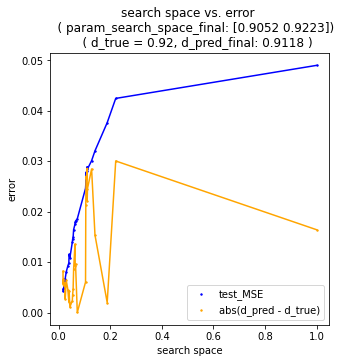


param true value: 0.85

generating samples (M=256, N=1000) param_search_space: [0. 1.] ... histogram shape: (750, 66)
fitting dnn model ... pred_params_MAE: 0.0526, d_pred: 0.8647
*** min_distance from d_true to train_params: 0.000679
*** min_distance from d_true to test_params: 0.002530
*** max(H_train): 152, max(H_sample): 134
*** train_MAX_abs_error: 0.1642
*** test_MAX_abs_error: 0.2219
*** abs(d_pred - d_true): 0.0147
pivot = d_pred: 0.8647, margin = 3*test_STD_abs_error = 0.1204

generating samples (M=256, N=1000) param_search_space: [0.7443 0.9851] ... histogram shape: (750, 50)
fitting dnn model ... pred_params_MAE: 0.0371, d_pred: 0.8710
*** min_distance from d_true to train_params: 0.000149
*** min_distance from d_true to test_params: 0.000347
*** max(H_train): 148, max(H_sample): 134
*** train_MAX_abs_error: 0.1385
*** test_MAX_abs_error: 0.1345
*** abs(d_pred - d_true): 0.0210
pivot = d_pred: 0.8710, margin = 3*test_STD_abs_error = 0.0816

generating samples (M=256, N=1000

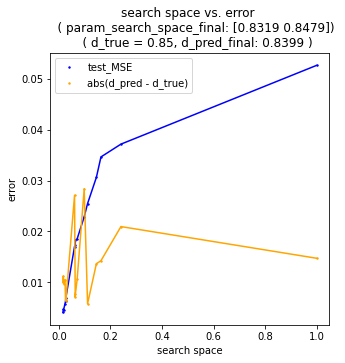


param true value: 0.66

generating samples (M=256, N=1000) param_search_space: [0. 1.] ... histogram shape: (750, 57)
fitting dnn model ... pred_params_MAE: 0.0534, d_pred: 0.6364
*** min_distance from d_true to train_params: 0.000048
*** min_distance from d_true to test_params: 0.001134
*** max(H_train): 154, max(H_sample): 129
*** train_MAX_abs_error: 0.1906
*** test_MAX_abs_error: 0.1907
*** abs(d_pred - d_true): 0.0236
pivot = d_pred: 0.6364, margin = 3*test_STD_abs_error = 0.1160

generating samples (M=256, N=1000) param_search_space: [0.5203 0.7524] ... histogram shape: (750, 23)
fitting dnn model ... pred_params_MAE: 0.0325, d_pred: 0.6110
*** min_distance from d_true to train_params: 0.000200
*** min_distance from d_true to test_params: 0.000684
*** max(H_train): 149, max(H_sample): 129
*** train_MAX_abs_error: 0.1159
*** test_MAX_abs_error: 0.1141
*** abs(d_pred - d_true): 0.0490
pivot = d_pred: 0.6110, margin = 3*test_STD_abs_error = 0.0703

generating samples (M=256, N=1000

fitting dnn model ... pred_params_MAE: 0.0059, d_pred: 0.5922
*** min_distance from d_true to train_params: 0.060982
*** min_distance from d_true to test_params: 0.061033
*** max(H_train): 151, max(H_sample): 129
*** train_MAX_abs_error: 0.0188
*** test_MAX_abs_error: 0.0157
*** abs(d_pred - d_true): 0.0678
pivot = d_pred: 0.5922, margin = 3*test_STD_abs_error = 0.0112

generating samples (M=256, N=1000) param_search_space: [0.581 0.599] ... histogram shape: (750, 16)
fitting dnn model ... pred_params_MAE: 0.0045, d_pred: 0.5917
*** min_distance from d_true to train_params: 0.061005
*** min_distance from d_true to test_params: 0.061007
*** max(H_train): 155, max(H_sample): 129
*** train_MAX_abs_error: 0.0119
*** test_MAX_abs_error: 0.0111
*** abs(d_pred - d_true): 0.0683
pivot = d_pred: 0.5917, margin = 3*test_STD_abs_error = 0.0083

generating samples (M=256, N=1000) param_search_space: [0.5834 0.599 ] ... histogram shape: (750, 15)
fitting dnn model ... pred_params_MAE: 0.0042, d_pre

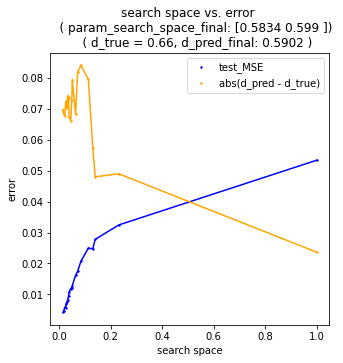


param true value: 0.25

generating samples (M=256, N=1000) param_search_space: [0. 1.] ... histogram shape: (750, 37)
fitting dnn model ... pred_params_MAE: 0.0663, d_pred: 0.2633
*** min_distance from d_true to train_params: 0.000896
*** min_distance from d_true to test_params: 0.000436
*** max(H_train): 151, max(H_sample): 136
*** train_MAX_abs_error: 0.2153
*** test_MAX_abs_error: 0.2164
*** abs(d_pred - d_true): 0.0133
pivot = d_pred: 0.2633, margin = 3*test_STD_abs_error = 0.1485

generating samples (M=256, N=1000) param_search_space: [0.1147 0.4118] ... histogram shape: (750, 4)
fitting dnn model ... pred_params_MAE: 0.0311, d_pred: 0.2568
*** min_distance from d_true to train_params: 0.000043
*** min_distance from d_true to test_params: 0.000957
*** max(H_train): 156, max(H_sample): 136
*** train_MAX_abs_error: 0.1274
*** test_MAX_abs_error: 0.1215
*** abs(d_pred - d_true): 0.0068
pivot = d_pred: 0.2568, margin = 3*test_STD_abs_error = 0.0731

generating samples (M=256, N=1000)

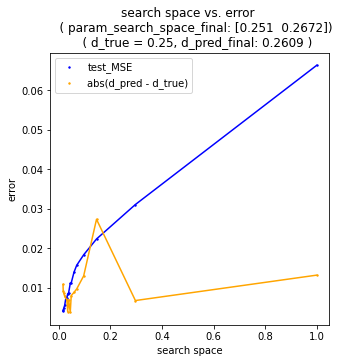

In [4]:
from scipy import stats
from scipy.stats import lognorm

# sample from lognormal
def sample_lognormal(config, size):
    return lognorm.rvs(s=config, size=size, random_state=RANDOM_STATE)

# fit
def exp_1():
    for d_true in [0.92, 0.85, 0.66, 0.25]:
#     for d_true in [0.85, 0.66, 0.25]:
        #reset_random_state(SEED)
        print()
        print(f'param true value: {d_true}')
        sample = sample_lognormal(config=d_true, size=256)
        res = estimator_exp_1(f=sample_lognormal, sample=sample, d_true=d_true)
        plot_search_space_size_vs_d_pred_error(res)

exp_1()

## Exp-2: 
Show that the error of predicting the input *sample* is "same" as for predicting the test-set

**Research question**: TBD

- Calculate the variance of the error $e = (d\_pred - d\_true)$ produced above.

> $ var_1(e) = E [ ( e - \mu ) ^ 2 ] = 1/n * \sum_i { ( e_i - \mu ) } ^ 2 $

> $ \sigma_1(e) = \sqrt { var_1(e) } $


- Calculate the avg. error of $\sigma_1(e)$:

> $ var_2(e) = 1/n * \sum_i { [ ( e_i - \mu ) ^ 2 - \sigma_1(e) ^ 2 ] } $

> $ \sigma_2(e) = \sqrt { var_2(e) } $

- Plot a graph:

> x: size of search-space

> y: error(sample) in red, error(test-data) in blue, confidence interval (sigma_2)

In [5]:
# # reset_random_state(SEED)

# d_true = 0.72
# print()
# print(f'param true value: {d_true}')
# sample = sample_lognormal(config=d_true, size=256)
# res = estimator_exp_1(f=sample_lognormal, sample=sample, d_true=d_true)

### Plot helper (2)

In [6]:
# TODO

In [7]:
# d_true = res['d_true']
# d_pred = np.array(res['d_pred'])

# e = d_pred - d_true
# n = len(d_pred)

# # Calculate the variance of the error
# var_1 = 1/n * np.sum( np.square( e - np.mean(e) ) )
# sigma_1 = np.sqrt(var_1)
# print()
# print(f'var_1: {var_1:.4f}, sigma_1: {sigma_1:.4f}')

# # Calculate the avg. error of sigma_1
# var_2 = 1/n * np.sum( np.square( e - sigma_1 ) )
# sigma_2 = np.sqrt(var_2)
# print()
# print(f'var_2: {var_2:.4f}, sigma_2: {sigma_2:.4f}')

# # Plot error(sample) in red, error(test-data) in blue, confidence interval (sigma_2)